# Initial Experiments w Hierarchical Attention Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a higher-order Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
x_i^{(t)} &\sim P(\cdot | x_{i-1}^{(t)}, \ldots, x_{i-m}^{(t)})
\end{align*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools

import sys;sys.path.append('..')
import utils

import tensorflow as tf

2023-07-26 21:21:07.434297: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 21:21:07.532197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 21:21:08.476089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices()

2023-07-26 21:21:09.808144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-26 21:21:09.837200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-26 21:21:09.837250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [109]:
# utilities for analyzing attention patterns
# TODO: create a module out of this

import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_per_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig = plt.figure(figsize=(num_mem_seqs*2,3))
    gs = gridspec.GridSpec(1, num_mem_seqs+1, width_ratios=[0.5]*num_mem_seqs+[0.1])
    axs = [fig.add_subplot(gs[i]) for i in range(num_mem_seqs)]
    cax = fig.add_subplot(gs[-1])
    im = None
    for t, ax in enumerate(axs):
        im = ax.imshow(attn_[t], cmap='gray', vmin=0, vmax=1)
        ax.set_xticks(range(len(mem_seqs_x[t])))
        ax.set_yticks(range(len(train_seqs_x)))
        ax.set_xticklabels(mem_seqs_x[t]);
        ax.set_yticklabels(train_seqs_x);
    fig.colorbar(im, cax=cax)
    axs[0].set_ylabel('input sequence')
    fig.supxlabel('memory sequences', y=0.)
    fig.suptitle('attention within each memory sequence')
    return fig

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x, **figkwargs):
    fig, ax = plt.subplots(**figkwargs)
    cmap = 'gray' if attn_.shape[-1] == 1 else None
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax);
    return fig


## Generate Data

In [3]:
n_states = 16
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))
len(state_tuples)

256

In [4]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [5]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)
    return states_seq

In [81]:
input_seq_len = 20 # length of input sequences
mem_seq_len = 2*m # length of each memory sequence
mem_size = 32 # number of memory sequences

n_train = 400
n_test = 400

def sample_seqs_dataset(n, input_seq_len):
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for _ in range(n)])

    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    return seqs_x, seqs_y


def sample_mem_dataset(mem_seq_len, mem_size):
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1) 
         for _ in range(mem_size)])
    # mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=n)
    mem_seqs = mem_seqs

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    return mem_seqs_x, mem_seqs_y

seqs_x_train, seqs_y_train = sample_seqs_dataset(n_train, input_seq_len)
seqs_x_test, seqs_y_test = sample_seqs_dataset(n_test, input_seq_len)

# NOTE: same memory buffer for all inputs
mem_seqs_x, mem_seqs_y = sample_mem_dataset(mem_seq_len, mem_size)
mem_seqs_x_train = np.repeat(np.expand_dims(mem_seqs_x, axis=0), axis=0, repeats=n_train)
mem_seqs_y_train = np.repeat(np.expand_dims(mem_seqs_y, axis=0), axis=0, repeats=n_train)
mem_seqs_x_test = np.repeat(np.expand_dims(mem_seqs_x, axis=0), axis=0, repeats=n_test)
mem_seqs_y_test = np.repeat(np.expand_dims(mem_seqs_y, axis=0), axis=0, repeats=n_test)


In [82]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (400, 20); seqs_y_train.shape: (400, 20)
mem_seqs_x_train.shape: (400, 32, 4); mem_seqs_y.shape: (400, 32, 4)


In [83]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)

## Hierarchical Attention Model

In [84]:
import tensorflow as tf
from tensorflow.keras import layers
from hierarchical_attention import HierarchicalAttention, MultiHeadHierarchicalAttention
from gating import SimpleHierarchicalAttentionGate

### Define Memory Model

### without self-attention, 1-head HierAttn

In [85]:
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=None, n_heads=n_heads, 
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        self.output_dense = layers.Dense(vocab_size, name='output')

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [86]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//1, n_heads=1, name='memory_model')

memory_model([seqs_x_train, mem_seqs_x_train, mem_seqs_y_train]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=5e-3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 mem_attn (MultiHeadHierarch  multiple                 12288     
 icalAttention)                                                  
                                                                 
 output (Dense)              multiple                  16640     
                                                                 
Total params: 45,312
Trainable params: 45,312
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-07-27 13:42:58.688402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [400,20]
	 [[{{node Placeholder/_3}}]]


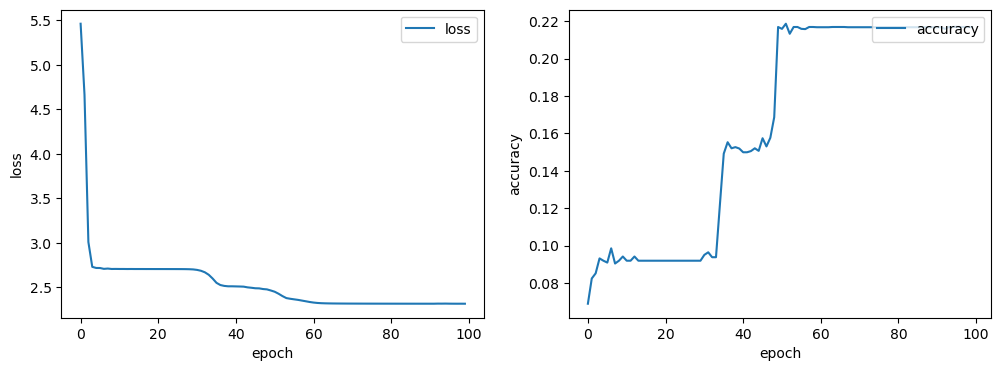

In [87]:
history = memory_model.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [88]:
memory_model.evaluate(train_ds)

7/7 [==============================] - 0s 26ms/step - loss: 2.3131 - accuracy: 0.2169


[2.31308913230896, 0.21687500178813934]

7/7 [==============================] - 0s 15ms/step


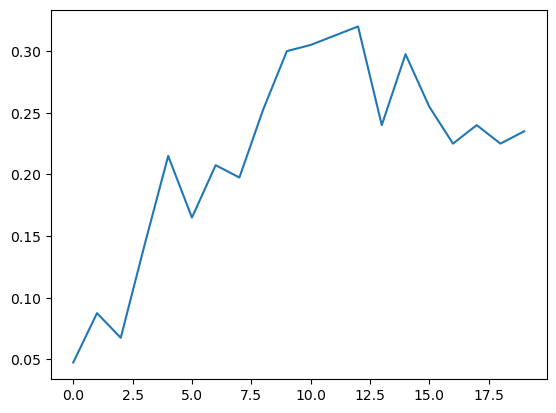

In [89]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

In [90]:
memory_model.evaluate(test_ds)

5/7 [====================>.........] - ETA: 0s - loss: 2.3764 - accuracy: 0.1992

2023-07-27 13:43:23.751183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [400,20]
	 [[{{node Placeholder/_3}}]]


7/7 [==============================] - 0s 33ms/step - loss: 2.3784 - accuracy: 0.1999


[2.378368377685547, 0.19987499713897705]

prediction: [[14  9 10 14  9 14 10  9  9  9  9 14  9 14 14 14 14 14 14  9]]
y: [ 0 14 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]
[[False False  True False  True  True False False False False  True False
   True False False False False False False False]]


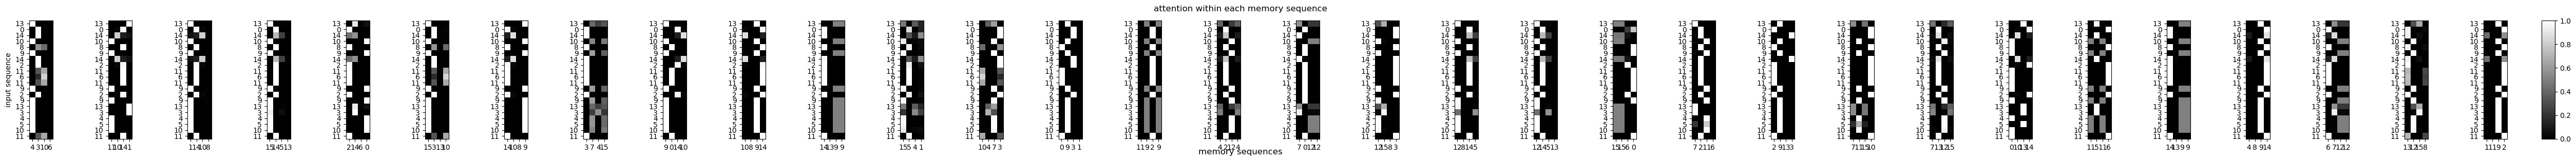

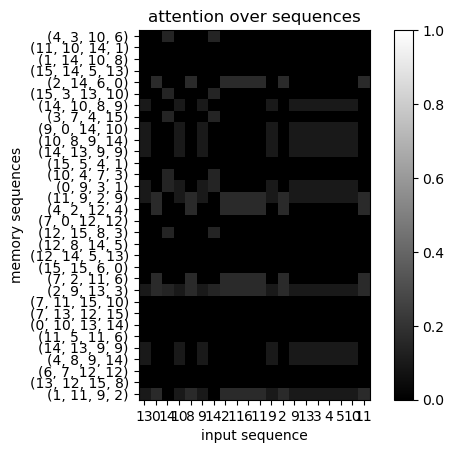

In [91]:
# choose sample input
b = 1
sample_input = seqs_x_train[b:b+1]
sample_mem_seq_x = mem_seqs_x_train[b:b+1]
sample_mem_seq_y = mem_seqs_y_train[b:b+1]

pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(f'prediction: {pred}')
print(f'y: {seqs_y_train[b]}')
print(pred == seqs_y_train[b])
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

### with self-attention, 1-head HierAttn

In [92]:
from transformer_modules import create_positional_encoding

# TODO: add this layer to some module

class MemoryAddPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, name="add_positional_embedding"):
        super().__init__(name=name)

    def build(self, input_shape):
        _, self.n_m, self.seq_length, self.vec_dim = input_shape
        self.pos_encoding = create_positional_encoding(length=self.seq_length, depth=self.vec_dim)

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.vec_dim, tf.float32))

        # add positional encoding
        x = x + self.pos_encoding[tf.newaxis, :, :]

        return x

In [93]:
from transformer_modules import AddPositionalEmbedding

class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [94]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//1, n_heads=1, name='memory_model')

memory_model([seqs_x_train[:32], mem_seqs_x_train[:32], mem_seqs_y_train[:32]]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

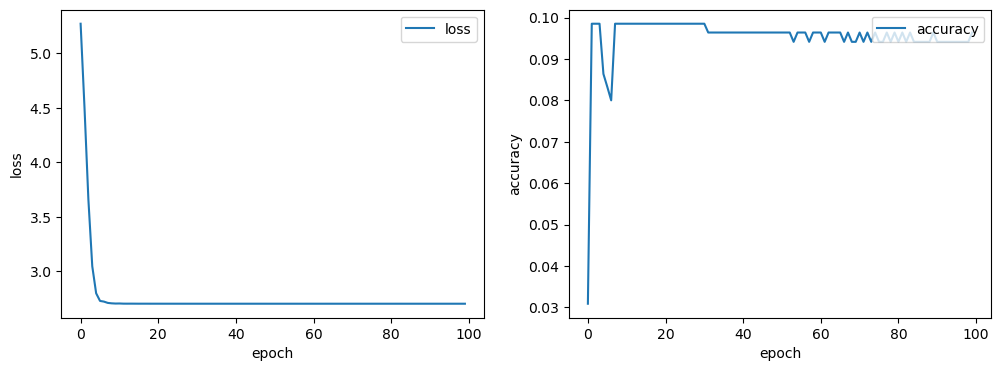

In [95]:
history = memory_model.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [96]:
memory_model.evaluate(train_ds)

7/7 [==============================] - 1s 72ms/step - loss: 2.7020 - accuracy: 0.0985


[2.701991081237793, 0.09849999845027924]

7/7 [==============================] - 1s 126ms/step


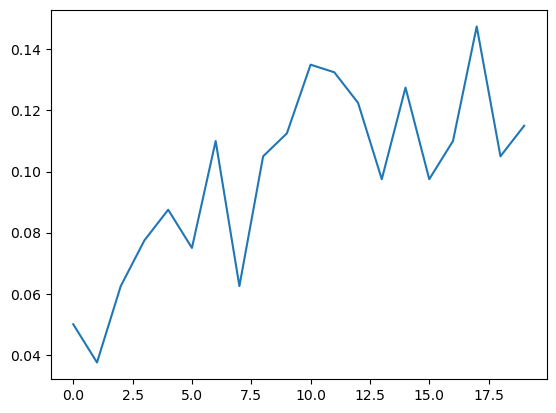

In [97]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

In [98]:
memory_model.evaluate(test_ds)

1/7 [===>..........................] - ETA: 0s - loss: 2.7098 - accuracy: 0.0953

7/7 [==============================] - 0s 50ms/step - loss: 2.7107 - accuracy: 0.0966


[2.7107415199279785, 0.09662500023841858]

2/7 [=======>......................] - ETA: 0s

7/7 [==============================] - 0s 50ms/step


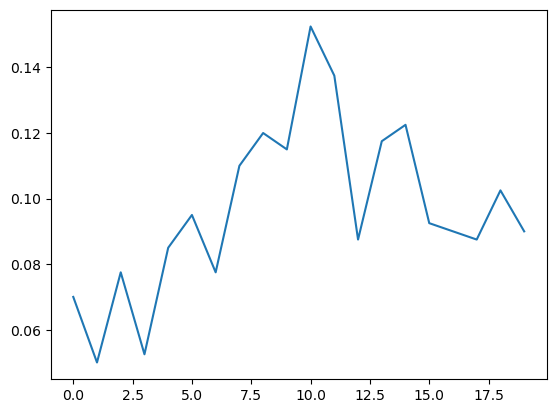

In [99]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

prediction: [[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]]
y: [ 0 14 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]
[[False False False False  True False False False False False  True False
   True False False False False False False False]]


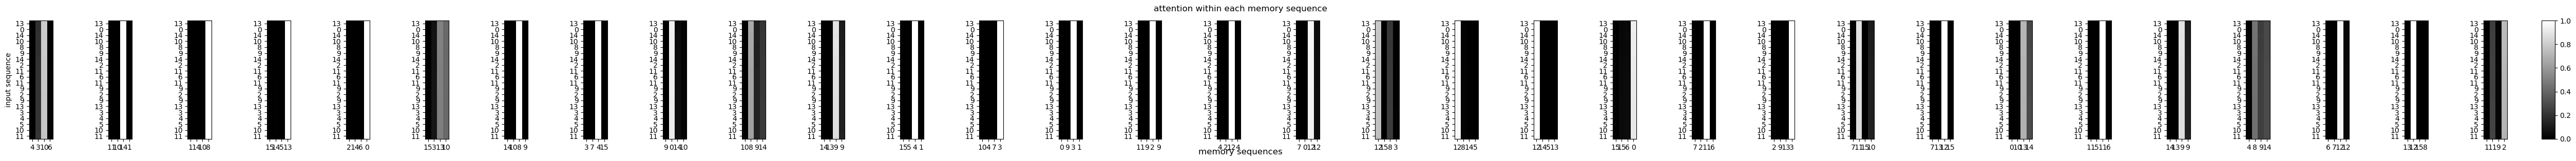

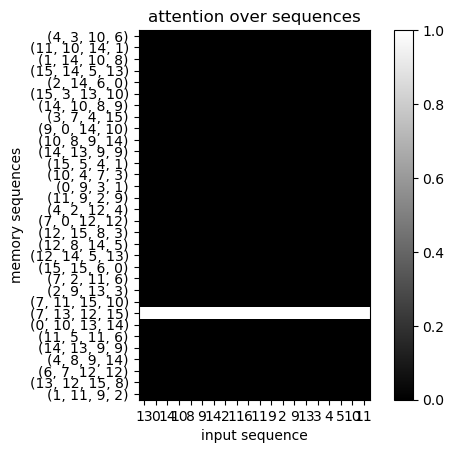

In [100]:
# choose sample input
b = 1
sample_input = seqs_x_train[b:b+1]
sample_mem_seq_x = mem_seqs_x_train[b:b+1]
sample_mem_seq_y = mem_seqs_y_train[b:b+1]

pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(f'prediction: {pred}')
print(f'y: {seqs_y_train[b]}')
print(pred == seqs_y_train[b])
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0]);

### with self-attention, multi-head HierAttn

In [101]:
from transformer_modules import AddPositionalEmbedding

class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [102]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model([seqs_x_train[:32], mem_seqs_x_train[:32], mem_seqs_y_train[:32]]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 16640     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 16640     
 ention)                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

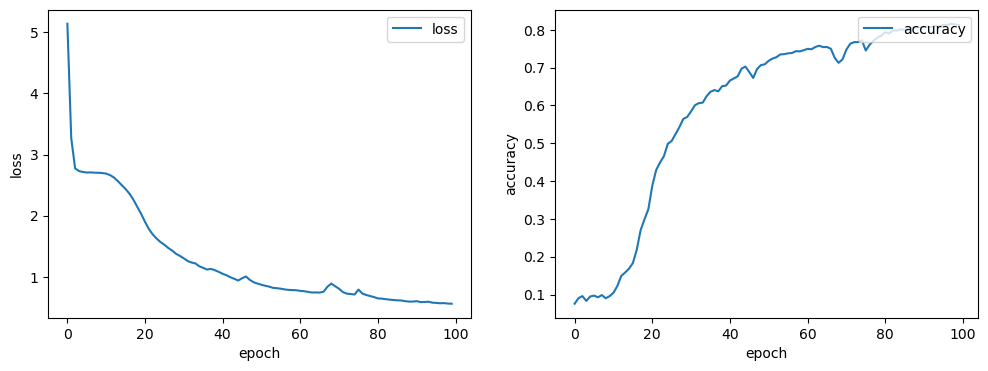

In [103]:
history = memory_model.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [104]:
memory_model.evaluate(train_ds)

7/7 [==============================] - 2s 157ms/step - loss: 0.5673 - accuracy: 0.8191


[0.5672903656959534, 0.8191249966621399]

7/7 [==============================] - 1s 99ms/step


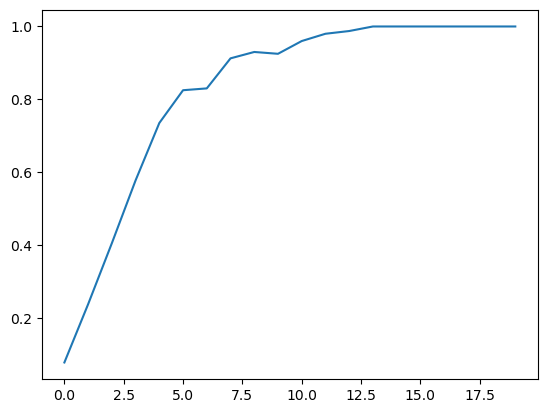

In [105]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

In [106]:
memory_model.evaluate(test_ds)

7/7 [==============================] - 1s 77ms/step - loss: 0.6499 - accuracy: 0.7946


[0.6499491930007935, 0.7946249842643738]

2/7 [=======>......................] - ETA: 0s

7/7 [==============================] - 1s 94ms/step


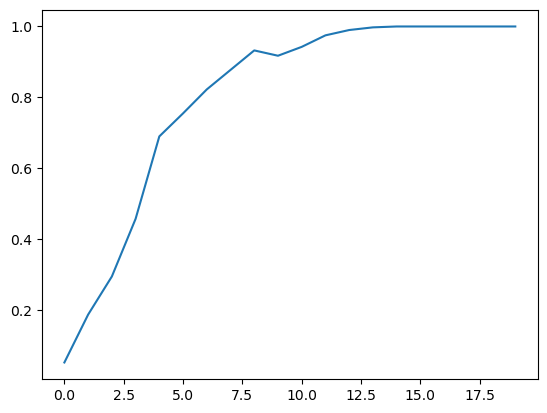

In [107]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

prediction: [[ 3  3 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]]
y: [ 0 14 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]
[[False False  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]]


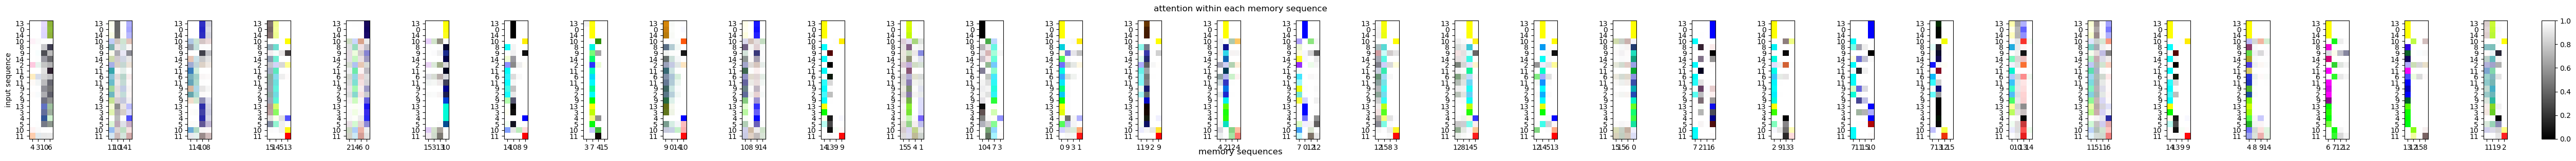

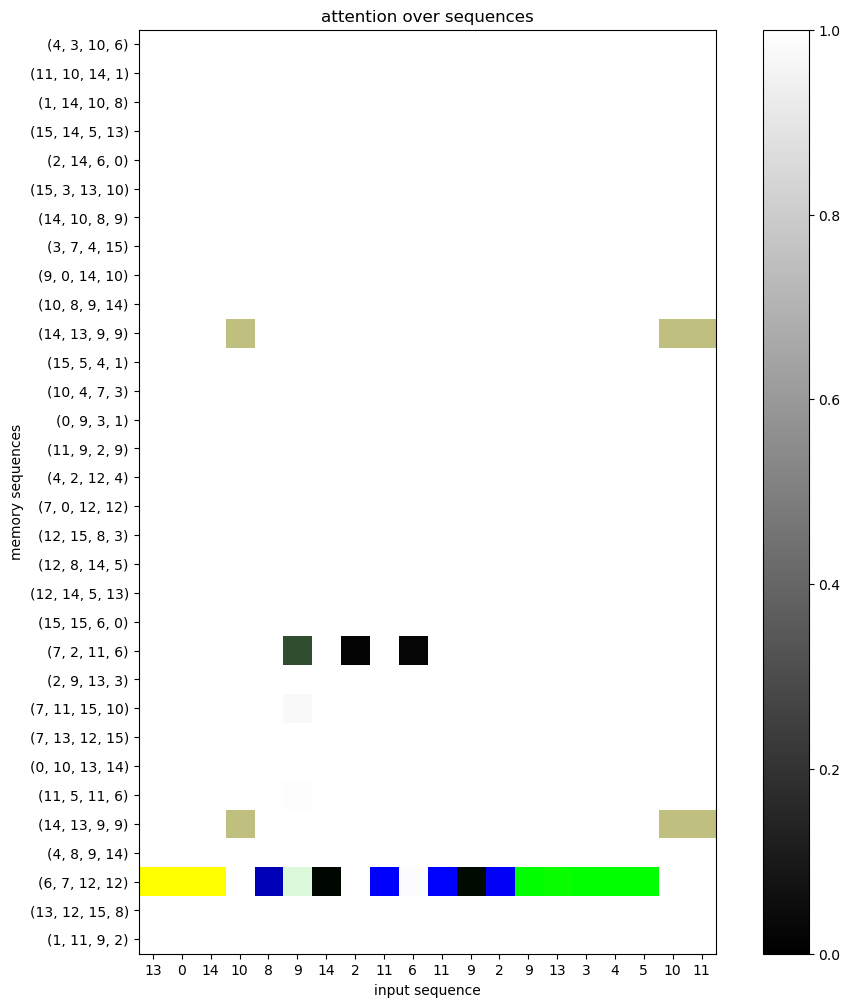

In [117]:
# choose sample input
b = 1
sample_input = seqs_x_train[b:b+1]
sample_mem_seq_x = mem_seqs_x_train[b:b+1]
sample_mem_seq_y = mem_seqs_y_train[b:b+1]

pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(f'prediction: {pred}')
print(f'y: {seqs_y_train[b]}')
print(pred == seqs_y_train[b])
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], figsize=(12, 12));

### with self-attention, multi-head HierAttn, and scalar gating

In [180]:
from transformer_modules import AddPositionalEmbedding

class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim//n_heads, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        
        self.memory_gate = SimpleHierarchicalAttentionGate(componentwise=False, name='mem_gate')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems, mem_seq_attn_mat, per_seq_attn_mat, attn_mat = self.hierarchical_mem_attention(
            [embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs],
            return_attention_scores=True)

        gate = self.memory_gate(mem_seq_attn_mat)

        self.last_gate = gate

        x = tf.multiply(gate, embedded_input_seqs) + tf.multiply(1 - gate, retrieved_mems)

        logits = self.output_dense(x)

        return logits

In [181]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model([seqs_x_train[:32], mem_seqs_x_train[:32], mem_seqs_y_train[:32]]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 10400     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 10400     
 ention)                                              

In [182]:
tf.keras.utils.plot_model(memory_model, show_shapes=True, show_layer_names=True, to_file=None)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

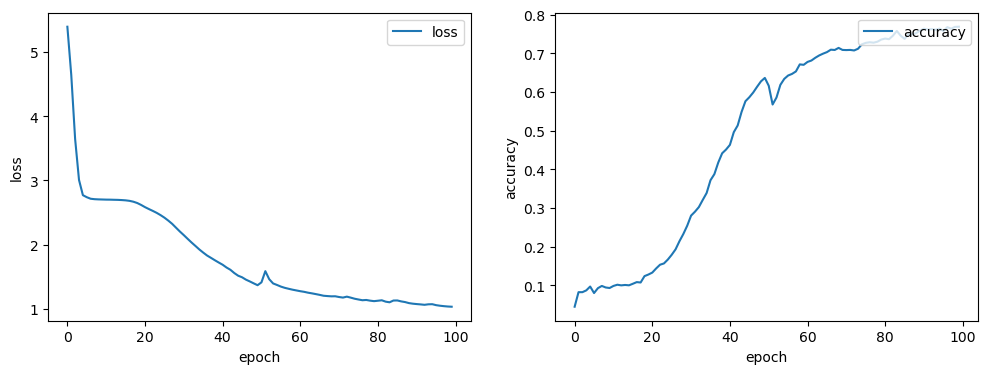

In [183]:
history = memory_model.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [184]:
memory_model.evaluate(train_ds)

7/7 [==============================] - 1s 111ms/step - loss: 1.0296 - accuracy: 0.7700


[1.02961003780365, 0.7699999809265137]

7/7 [==============================] - 1s 115ms/step


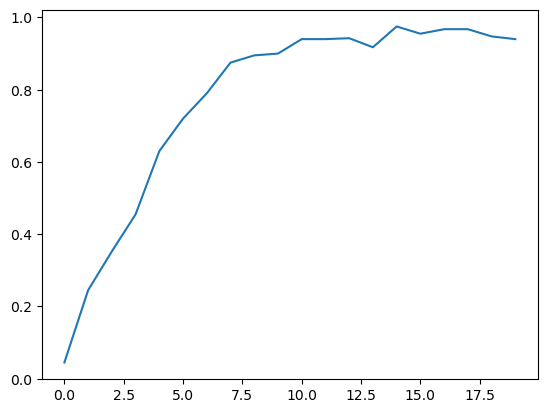

In [185]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

In [186]:
memory_model.evaluate(test_ds)

7/7 [==============================] - 1s 138ms/step - loss: 1.1525 - accuracy: 0.7533


[1.1524652242660522, 0.753250002861023]

7/7 [==============================] - 1s 93ms/step


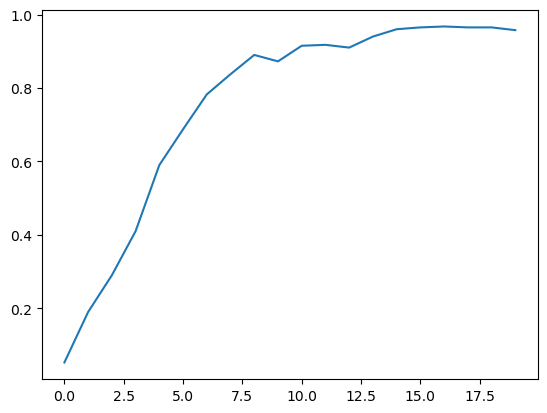

In [187]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

prediction: [[ 4 15 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]]
y: [ 0 14 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]
[[False False  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True]]


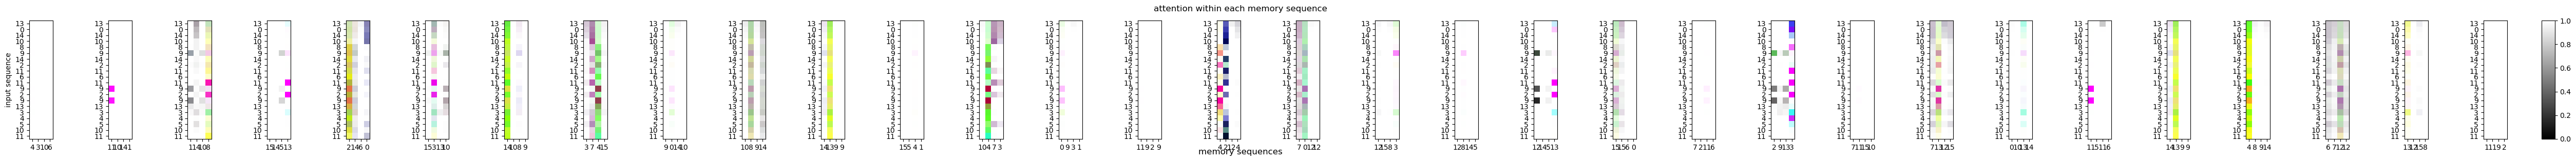

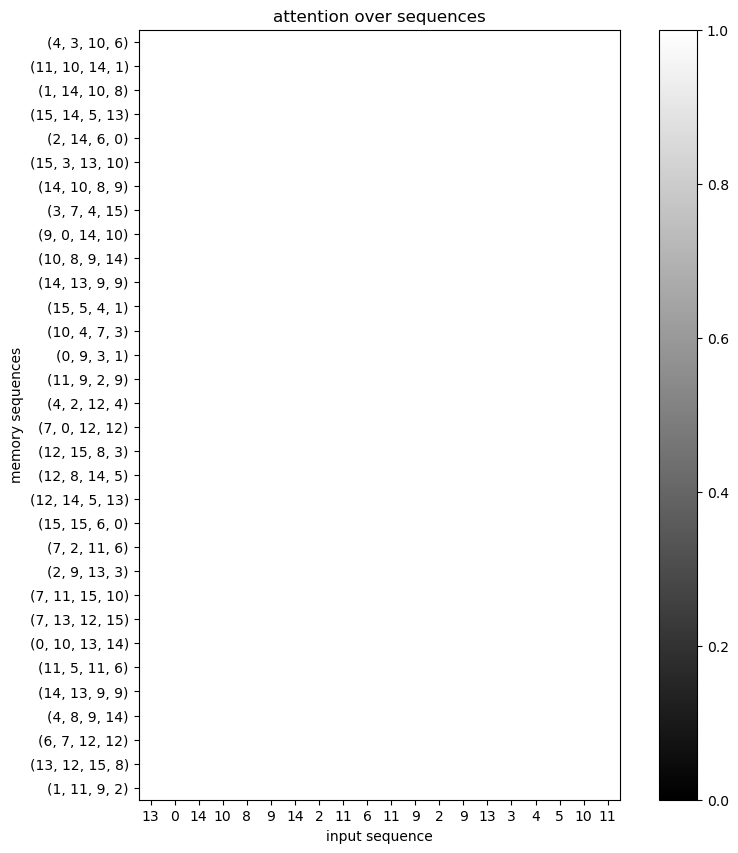

In [201]:
# choose sample input
b = 1
sample_input = seqs_x_train[b:b+1]
sample_mem_seq_x = mem_seqs_x_train[b:b+1]
sample_mem_seq_y = mem_seqs_y_train[b:b+1]

pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(f'prediction: {pred}')
print(f'y: {seqs_y_train[b]}')
print(pred == seqs_y_train[b])
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], figsize=(10, 10));

In [200]:
np.array(memory_model.last_gate[0]).T

array([[0.62174183, 0.62174183, 0.62174183, 0.62174183, 0.62174183,
        0.62174183, 0.62174183, 0.62174183, 0.62174183, 0.62174183,
        0.62174183, 0.62174183, 0.62174183, 0.62174183, 0.62174183,
        0.62174183, 0.62174183, 0.62174183, 0.62174183, 0.62174183]],
      dtype=float32)

### with self-attention, multi-head HierAttn, and componentwise (vector) gating

In [202]:
from transformer_modules import AddPositionalEmbedding

class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim//n_heads, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')
        
        self.memory_gate = SimpleHierarchicalAttentionGate(
            componentwise=True, mem_dim=embedding_dim, name='mem_gate')

        self.output_dense = layers.Dense(vocab_size, name='output')

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems, mem_seq_attn_mat, per_seq_attn_mat, attn_mat = self.hierarchical_mem_attention(
            [embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs],
            return_attention_scores=True)

        gate = self.memory_gate(mem_seq_attn_mat)

        self.last_gate = gate

        x = tf.multiply(gate, embedded_input_seqs) + tf.multiply(1 - gate, retrieved_mems)

        logits = self.output_dense(x)

        return logits

In [203]:
vocab_size = len(state_tuples)
embedding_dim = 64

memory_model = MemoryModel(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, name='memory_model')

memory_model([seqs_x_train[:32], mem_seqs_x_train[:32], mem_seqs_y_train[:32]]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  16384     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 10400     
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 10400     
 ention)                                              

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

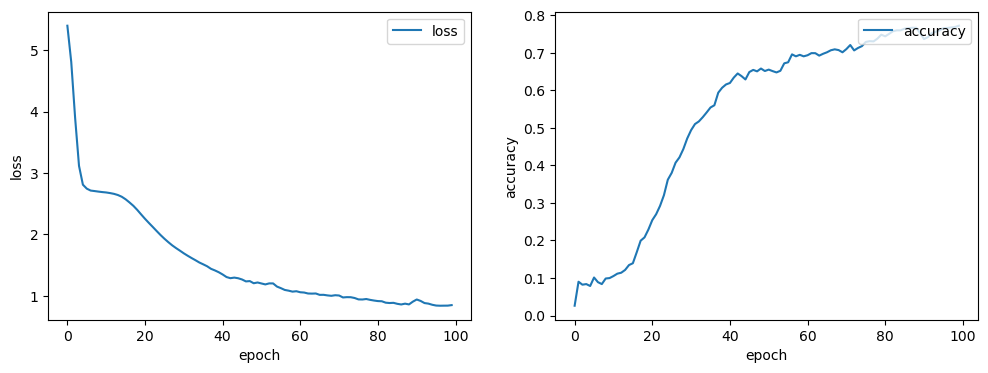

In [205]:
history = memory_model.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

In [206]:
memory_model.evaluate(train_ds)

7/7 [==============================] - 1s 94ms/step - loss: 0.8233 - accuracy: 0.7711


[0.8232855200767517, 0.7711250185966492]

7/7 [==============================] - 1s 121ms/step


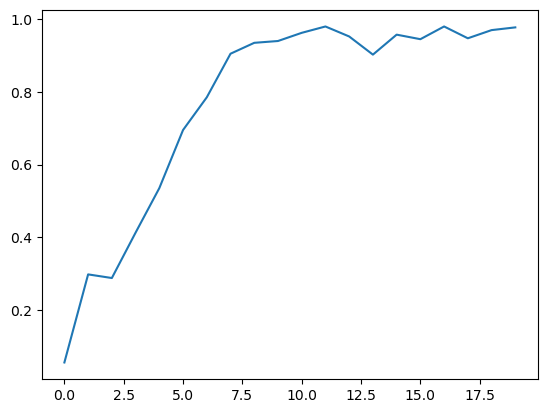

In [207]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

In [208]:
memory_model.evaluate(test_ds)

1/7 [===>..........................] - ETA: 0s - loss: 0.9357 - accuracy: 0.7492

7/7 [==============================] - 1s 74ms/step - loss: 0.9242 - accuracy: 0.7514


[0.9242092370986938, 0.7513750195503235]

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 1s 76ms/step


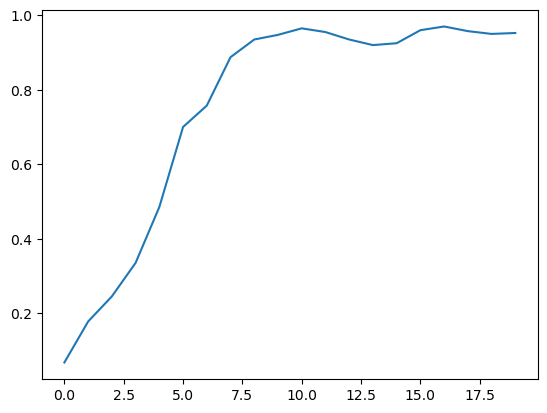

In [209]:
# plot accuracy as a function of position in sequence
preds = memory_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_test, axis=0)
plt.plot(acc_by_pos)

prediction: [[14 15 15  7  9 14  2 11  6 11  9  2  9  2  3  4  5 10 11  7]]
y: [ 0 14 10  8  9 14  2 11  6 11  9  2  9 13  3  4  5 10 11  7]
[[False False False False  True  True  True  True  True  True  True  True
   True False  True  True  True  True  True  True]]


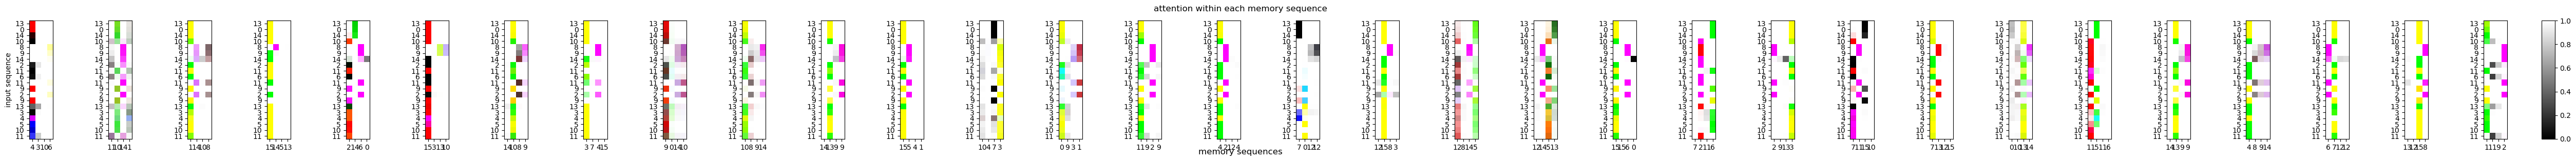

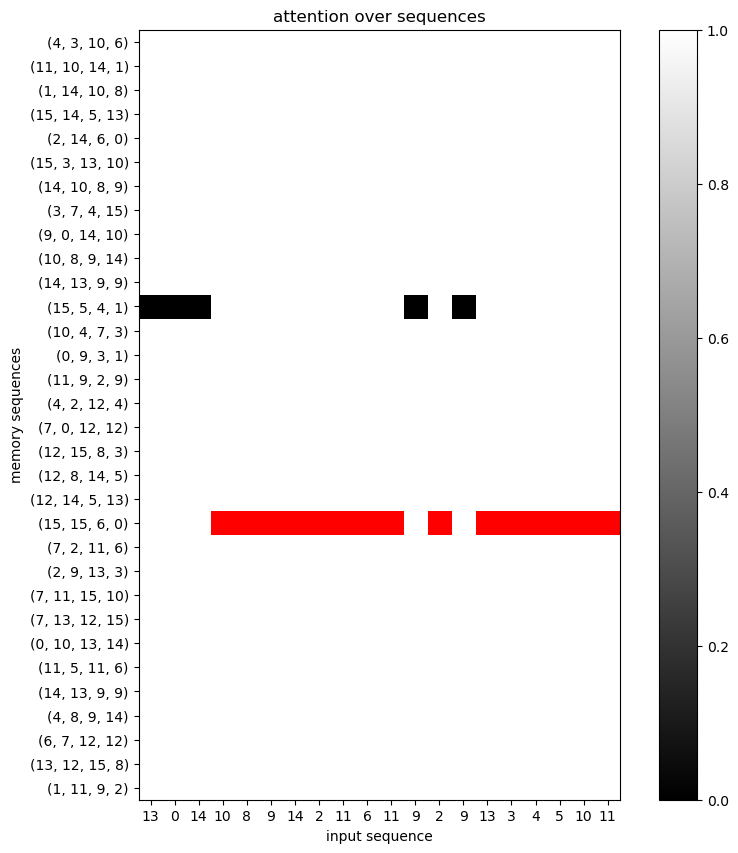

In [210]:
# choose sample input
b = 1
sample_input = seqs_x_train[b:b+1]
sample_mem_seq_x = mem_seqs_x_train[b:b+1]
sample_mem_seq_y = mem_seqs_y_train[b:b+1]

pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
pred = np.argmax(pred, axis=-1)
print(f'prediction: {pred}')
print(f'y: {seqs_y_train[b]}')
print(pred == seqs_y_train[b])
attn_ = memory_model.hierarchical_mem_attention.last_per_seq_attn_mat[0]

fig = plot_per_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])

attn_ = memory_model.hierarchical_mem_attention.last_mem_seq_attn_mat[0]

plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0], figsize=(10, 10));

In [216]:
np.mean(np.array(memory_model.last_gate[0]), axis=1)

array([0.5423255 , 0.5423255 , 0.5423255 , 0.5423255 , 0.5423255 ,
       0.5423255 , 0.5423255 , 0.5423255 , 0.5423182 , 0.5423255 ,
       0.5423255 , 0.5423255 , 0.5423255 , 0.5423255 , 0.5423255 ,
       0.5423255 , 0.5422958 , 0.5423255 , 0.54232544, 0.54232514],
      dtype=float32)

In [217]:
memory_model.last_gate[0]

<tf.Tensor: shape=(20, 64), dtype=float32, numpy=
array([[0.70216984, 0.90982306, 0.68926185, ..., 0.8103811 , 0.50552624,
        0.28642744],
       [0.70216984, 0.90982306, 0.68926185, ..., 0.8103811 , 0.50552624,
        0.2864274 ],
       [0.70216984, 0.90982306, 0.68926185, ..., 0.8103811 , 0.50552624,
        0.2864274 ],
       ...,
       [0.70216984, 0.90982306, 0.68926185, ..., 0.8103811 , 0.50552624,
        0.2864274 ],
       [0.70217   , 0.9098228 , 0.68926144, ..., 0.8103805 , 0.5055263 ,
        0.2864284 ],
       [0.7021708 , 0.9098218 , 0.6892597 , ..., 0.8103782 , 0.5055267 ,
        0.2864326 ]], dtype=float32)>